In [1]:
from tqdm import tqdm
import torch
import numpy as np
from monai.networks.nets import resnet10
from monai.visualize.class_activation_maps import GradCAMpp
from dicom_utils import *
from helper import *
import matplotlib.pyplot as plt

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

csv_path = f"../../../data/classification/train_labels.csv"

f_model_path = f"./models/FLAIR_model"
f_model = resnet10(spatial_dims=3, n_input_channels=1, num_classes=1)
f_model, f_model_summary = load_model(f_model, f_model_path)
f_model.to(device)

t_model_path = f"./models/T1wCE_model"
t_model = resnet10(spatial_dims=3, n_input_channels=1, num_classes=1)
t_model, t_model_summary = load_model(t_model, t_model_path)
t_model.to(device)

f_cam = GradCAMpp(nn_module=f_model, target_layers="layer4")
t_cam = GradCAMpp(nn_module=t_model, target_layers="layer4")

#_, f_val_dl = get_train_data_generators(csv_path, 'FLAIR', f_model_summary['num_3d_images'], 1)
#_, t_val_dl = get_train_data_generators(csv_path, 'T1wCE', t_model_summary['num_3d_images'], 1)
f_val_dl = get_test_data_generators(csv_path, 'FLAIR', t_model_summary['num_3d_images'], 1)
t_val_dl = get_test_data_generators(csv_path, 'T1wCE', t_model_summary['num_3d_images'], 1)

f_results = []
t_results = []
f_image_l = []
t_image_l = []
f_ids = []
t_ids = []
f_true_labels = []
t_true_labels = []
f_pred_labels = []
t_pred_labels = []

print(f_val_dl)

f_epoch_iterator_val = tqdm(f_val_dl)
t_epoch_iterator_val = tqdm(t_val_dl)
for f_batch, t_batch in zip(f_epoch_iterator_val, t_epoch_iterator_val):
    f_images = f_batch["image"].to(device)
    t_images = t_batch["image"].to(device)
    
    f_true_labels.append(f_batch["target"].to(device).cpu().numpy())
    t_true_labels.append(t_batch["target"].to(device).cpu().numpy())
    
    #print(f_images.shape)
    
    f_the_slice = f_images.shape[-1] // 2
    t_the_slice = t_images.shape[-1] // 2
    f_image_l.append(f_images[..., f_the_slice].cpu().detach())
    t_image_l.append(t_images[..., t_the_slice].cpu().detach())
    
    f_ids.append(f_batch["id"].to(device).cpu().numpy())
    t_ids.append(t_batch["id"].to(device).cpu().numpy())
    
    f_pred_labels.append(f_model(f_images).sigmoid().detach().cpu().numpy())
    t_pred_labels.append(t_model(t_images).sigmoid().detach().cpu().numpy())
    
    result = f_cam(x=f_images)
    result = result[...,f_the_slice].cpu().detach()
    f_results.append(result)
    
    result = t_cam(x=t_images)
    result = result[...,t_the_slice].cpu().detach()
    t_results.append(result)

100%|█████████▉| 467/468 [05:48<00:00,  1.34it/s]


In [15]:
with open('../figs/results.csv', 'w') as f:
    f.write('f_true,t_true,f_pred,t_pred,f_id,t_id\n')
    for f_true, t_true, f_pred, t_pred, f_id, t_id in zip (f_true_labels, t_true_labels, f_pred_labels, t_pred_labels, f_ids, t_ids):
        f.write(f'{f_true[0]},{t_true[0]},{f_pred[0]},{t_pred[0]},{f_id},{t_id}\n')

[ True]


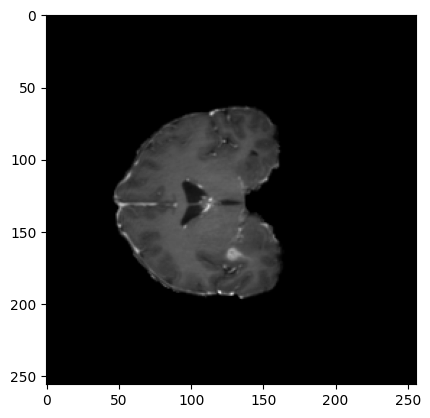

In [13]:
plt.imshow(t_image_l[0][0][0], cmap="grey")
print(f_ids[0] == t_ids[0])

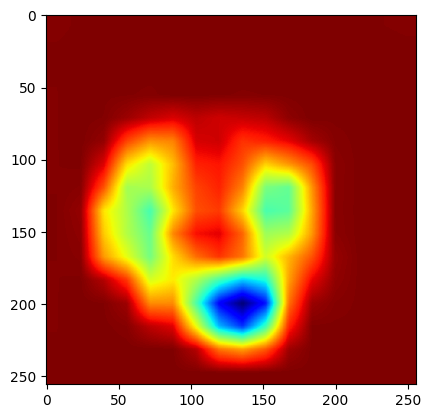

In [12]:
plt.imshow(t_results[0][0][0], cmap="jet")

In [ ]:
for i in range(len(t_image_l)):
    plt.imshow(t_image_l[i][0][0], cmap="grey")
    plt.savefig(f'../figs/T1wCE/t_img_{i}.png')
    
for i in range(len(f_image_l)):
    plt.imshow(f_image_l[i][0][0], cmap="grey")
    plt.savefig(f'../figs/flair/f_img_{i}.png')
    
for i in range(len(t_results)):
    plt.imshow(t_results[i][0][0], cmap="jet")
    plt.savefig(f'../figs/T1wCE/t_res_{i}.png')
    
for i in range(len(f_results)):
    plt.imshow(f_results[i][0][0], cmap="jet")
    plt.savefig(f'../figs/flair/f_res_{i}.png')

In [ ]:
plt.imshow(t_results[0][0][0], cmap="jet")

In [ ]:
print(f_ids)

In [ ]:
print(t_ids)

In [ ]:
dicom_files = [os.path.join('../../data/classification/train/00550/FLAIR/', file) for file in os.listdir('../../data/classification/train/00550/FLAIR/') if file.endswith('.dcm')]
dicom_files = sorted(dicom_files, key=lambda x: int(x.split('-')[1].split('.')[0]))
images = np.array([pydicom.dcmread(dicom_files[l]).pixel_array for l in range(len(dicom_files))])
images = (images - np.min(images)) / np.max(images)
for j, i in enumerate(images):
    print(i.shape)
    #plt.imshow(i, cmap='grey')
